In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.datasets import fetch_lfw_people
# min_faces_per_person signifies how many photos should atleast be there so as to include when extracting
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

images = lfw_people.images
images.shape

(1288, 50, 37)

In [ ]:
# But for easy operations we will be using 1D form of these matrices We will be directly using the data function. This here will be our feature variables
X = lfw_people.data
print(X.shape)

y = lfw_people.target
print(y.shape)

names = lfw_people.target_names
print(names.shape)

(1288, 1850)
(1288,)
(7,)


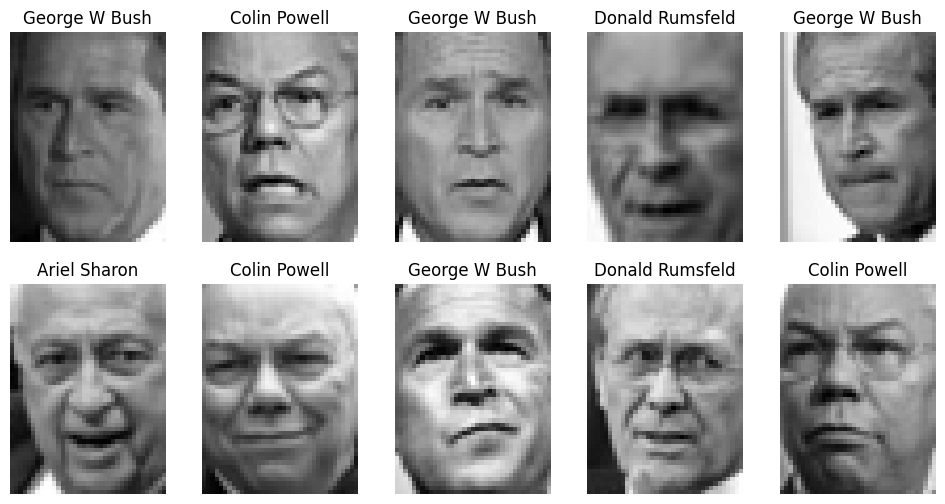

In [ ]:
i = 0

plt.figure(figsize=(12, 6))

while i < 10:
    random_index = np.random.randint(0, len(y))
    # print(f'at {random_index}, the photo is of {names[random_index]}')

    plt.subplot(2, 5, i + 1)
    plt.imshow(images[random_index], cmap='gray')
    plt.title(f'{names[y[random_index]]}')
    plt.axis('off')

    i += 1

plt.show()

In [ ]:
# Display the head of the dataset
print(X[:5])

[[0.9973857  0.99607843 0.9921568  ... 0.38169935 0.38823533 0.3803922 ]
 [0.14771242 0.19738562 0.1751634  ... 0.45751634 0.44444445 0.53594774]
 [0.34379086 0.39477125 0.49150327 ... 0.709804   0.72156864 0.7163399 ]
 [0.04705882 0.01699346 0.02352941 ... 0.06535948 0.14248367 0.20130719]
 [0.47189546 0.45882353 0.4862745  ... 0.07843138 0.2509804  0.2784314 ]]


In [ ]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Standardize the data
def standardize_data(X_train, X_test):
    mean = np.mean(X_train, axis=0)
    std = np.std(X_train, axis=0)

    X_train_std = (X_train - mean) / std
    X_test_std = (X_test - mean) / std

    return X_train_std, X_test_std

# Usage:
X_train_std, X_test_std = standardize_data(X_train, X_test)
print('Standard Deviation in train dataset is: \n' , X_train_std)
print('Standard Deviation in test dataset is: \n' , X_test_std)

Standard Deviation in train dataset is: 
 [[ 0.3428303  -0.10368288 -0.18801571 ...  0.93374085  1.0484188
   1.1166878 ]
 [-0.67268544 -0.5039668  -0.14957501 ...  1.5463196   1.6000024
   1.6235324 ]
 [-0.18319221 -0.21697079 -0.2648971  ...  1.0113919   1.1001297
   1.163936  ]
 ...
 [ 1.6724985   1.0669589   0.45778805 ... -1.1369472  -0.95969075
  -0.8033074 ]
 [ 0.7738767   0.75730497  0.9344529  ... -1.4863758  -1.3690693
  -1.2800847 ]
 [-0.24894501  0.28149596  0.42703566 ...  0.51528955  0.7166067
   0.8460845 ]]
Standard Deviation in test dataset is: 
 [[ 0.3209127  -0.02060509  0.07338123 ...  1.4600409  -0.11938744
  -0.4124359 ]
 [ 0.38666552  0.31170607  0.15026262 ... -0.9730177  -0.86919653
  -0.71740156]
 [-1.4690251  -1.7727914  -1.9101592  ...  0.07958215  0.25120795
   0.43373656]
 ...
 [ 0.26977164  0.25128585  0.17332688 ...  1.6541679   1.6172395
   1.0436679 ]
 [-1.3009902  -1.4706904  -1.2566673  ...  0.8215788   0.76831764
   0.794541  ]
 [-0.24894501  0.5533

# Implementing random forest before PCA

In [ ]:
def get_confusion_matrix(y_true, y_pred, num_classes):
    conf_matrix = np.zeros((num_classes, num_classes), dtype=int)

    for i in range(len(y_true)):
        conf_matrix[y_true[i], y_pred[i]] += 1

    return conf_matrix

def get_classification_report_rf(y_true, y_pred, target_names=None):
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    num_classes = len(unique_classes)

    # Initialize variables to store per-class metrics
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i, c in enumerate(unique_classes):
        true_positive = np.sum((y_true == c) & (y_pred == c))
        false_positive = np.sum((y_true != c) & (y_pred == c))
        false_negative = np.sum((y_true == c) & (y_pred != c))

        precision[i] = true_positive / max((true_positive + false_positive), 1)
        recall[i] = true_positive / max((true_positive + false_negative), 1)
        f1_score[i] = 2 * (precision[i] * recall[i]) / max((precision[i] + recall[i]), 1)

    # Calculate overall metrics
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Construct the classification report
    report = f"{'':<15}{'Precision':<15}{'Recall':<15}{'F1 Score':<15}\n"
    for i, c in enumerate(unique_classes):
        report += f"{f'{target_names[c]}' if target_names is not None else 'Class '}{c:<14}{precision[i]:<15.4f}{recall[i]:<15.4f}{f1_score[i]:<15.4f}\n"

    report += f"\n{'Macro Average':<15}{macro_precision:<15.4f}{macro_recall:<15.4f}{macro_f1_score:<15.4f}"

    return report


def plot_confusion_matrix_rf(conf_matrix_rf, target_names=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Random Forest Confusion Matrix')
    plt.show()

def calculate_accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

Custom Accuracy Score for Random Forest (Before PCA): 0.6008
Random Forest Classification Report (Before PCA):
                Precision      Recall         F1 Score       
Ariel Sharon0             1.0000         0.0400         0.0769         
Colin Powell1             0.6379         0.7255         0.6789         
Donald Rumsfeld2             0.4545         0.2632         0.2392         
George W Bush3             0.5868         0.9423         0.7232         
Gerhard Schroeder4             0.5000         0.1667         0.1667         
Hugo Chavez5             1.0000         0.2143         0.3529         
Tony Blair6             0.6667         0.2963         0.3951         

Macro Average  0.6923         0.3783         0.3761         


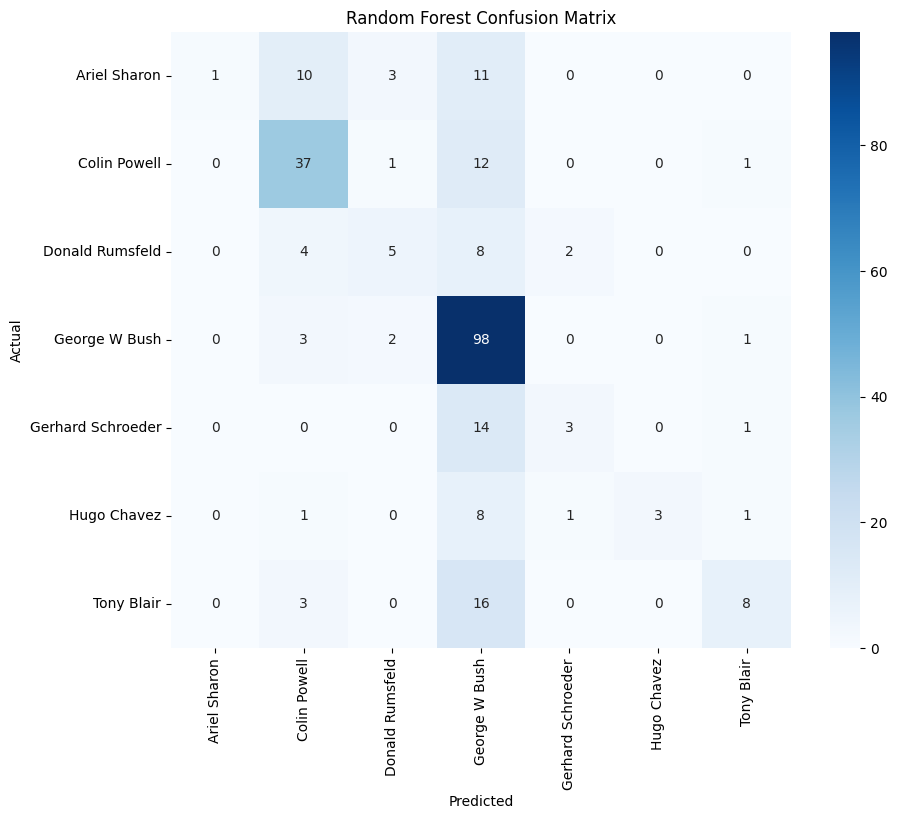

In [ ]:


# Initializing Random Forest Classifier with the help of sklearn
rf_classifier_before_pca = RandomForestClassifier(n_estimators=100, random_state=0)

# Training the classifier
rf_classifier_before_pca.fit(X_train, y_train)

# Predict labels for the test set
y_pred_rf_before_pca = rf_classifier_before_pca.predict(X_test)

# Calculating the accuracy using random forest classifier
accuracy_rf_before_pca = calculate_accuracy(y_test, y_pred_rf_before_pca)
print(f"Custom Accuracy Score for Random Forest (Before PCA): {accuracy_rf_before_pca:.4f}")

# Calculate the number of unique classes
num_classes = len(np.unique(y))


conf_matrix_rf_before_pca = get_confusion_matrix(y_test, y_pred_rf_before_pca, num_classes)

# Displaying the classification report for Random Forest classifier before PCA
report_rf_before_pca = get_classification_report_rf(y_test, y_pred_rf_before_pca, target_names=lfw_people.target_names)
print("Random Forest Classification Report (Before PCA):\n", report_rf_before_pca)

# Plotting the confusion matrix for Random Forest classifier before PCA
plot_confusion_matrix_rf(conf_matrix_rf_before_pca, target_names=lfw_people.target_names)

# Implementing KNN before PCA

In [ ]:
def k_nearest_neighbors(X_train, y_train, X_test, k=5):
    n_test = X_test.shape[0]
    y_pred = np.zeros(n_test, dtype=int)

    i = 0
    while i < n_test:
        # Calculate distances from the test sample to all training samples
        distances = np.linalg.norm(X_train - X_test[i], axis=1)

        # Find the indices of the k-nearest neighbors
        nearest_indices = np.argsort(distances)[:k]

        # Get the labels of the k-nearest neighbors
        nearest_labels = y_train[nearest_indices]

        # Predict the class based on the majority class among neighbors
        unique, counts = np.unique(nearest_labels, return_counts=True)
        y_pred[i] = unique[np.argmax(counts)]

        i += 1

    return y_pred

def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
def get_classification_report(y_true, y_pred, target_names=None):
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    num_classes = len(unique_classes)

    # Initialize variables to store per-class metrics
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i, c in enumerate(unique_classes):
        true_positive = np.sum((y_true == c) & (y_pred == c))
        false_positive = np.sum((y_true != c) & (y_pred == c))
        false_negative = np.sum((y_true == c) & (y_pred != c))

        precision[i] = true_positive / max((true_positive + false_positive), 1)
        recall[i] = true_positive / max((true_positive + false_negative), 1)
        f1_score[i] = 2 * (precision[i] * recall[i]) / max((precision[i] + recall[i]), 1)

    # Calculate overall metrics
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Construct the classification report
    report = f"{'':<15}{'Precision':<15}{'Recall':<15}{'F1 Score':<15}\n"
    for i, c in enumerate(unique_classes):
        report += f"{f'{target_names[c]}' if target_names is not None else 'Class '}{c:<14}{precision[i]:<15.4f}{recall[i]:<15.4f}{f1_score[i]:<15.4f}\n"

    report += f"\n{'Macro Average':<15}{macro_precision:<15.4f}{macro_recall:<15.4f}{macro_f1_score:<15.4f}"

    return report



def plot_confusion_matrix(conf_matrix, target_names=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

k-NN without PCA Accuracy: 0.5891


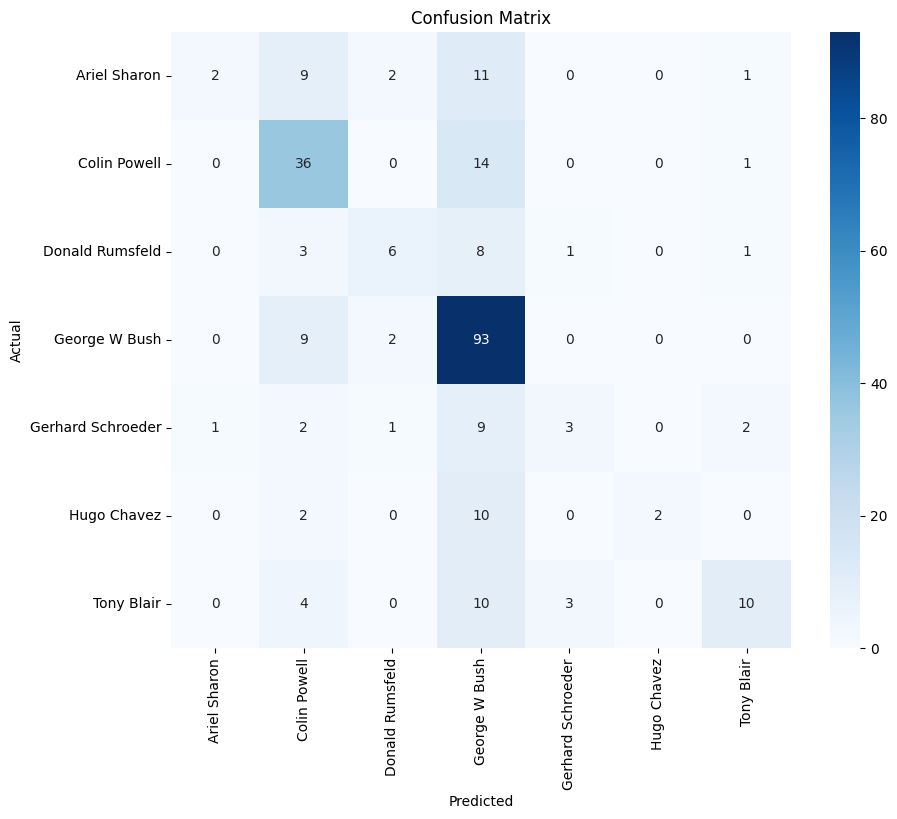

Classification Report for k-NN without PCA:
                Precision      Recall         F1 Score       
Ariel Sharon0             0.6667         0.0800         0.1067         
Colin Powell1             0.5538         0.7059         0.6207         
Donald Rumsfeld2             0.5455         0.3158         0.3445         
George W Bush3             0.6000         0.8942         0.7181         
Gerhard Schroeder4             0.4286         0.1667         0.1429         
Hugo Chavez5             1.0000         0.1429         0.2500         
Tony Blair6             0.6667         0.3704         0.4762         

Macro Average  0.6373         0.3823         0.3799         


In [ ]:
# Train a k-NN model without PCA
k = 9
y_pred_knn = k_nearest_neighbors(X_train_std, y_train, X_test_std, k)

# Evaluate the k-NN model without PCA
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"k-NN without PCA Accuracy: {accuracy_knn:.4f}")

# Create the confusion matrix for k-NN without PCA
conf_matrix_knn = get_confusion_matrix(y_test, y_pred_knn, num_classes=len(np.unique(y_test)))

# Display the confusion matrix for k-NN without PCA
plot_confusion_matrix(conf_matrix_knn, target_names=names)

# Create and display the classification report for k-NN without PCA
classification_report_knn = get_classification_report(y_test, y_pred_knn, target_names=names)
print("Classification Report for k-NN without PCA:\n", classification_report_knn)

In [ ]:
# Compute the mean of the data
mean = np.mean(X_train, axis=0)

# Center the data
X_centered = X_train - mean

In [ ]:
# Calculate the covariance matrix using NumPy
cov_matrix = np.cov(X_centered, rowvar=False)

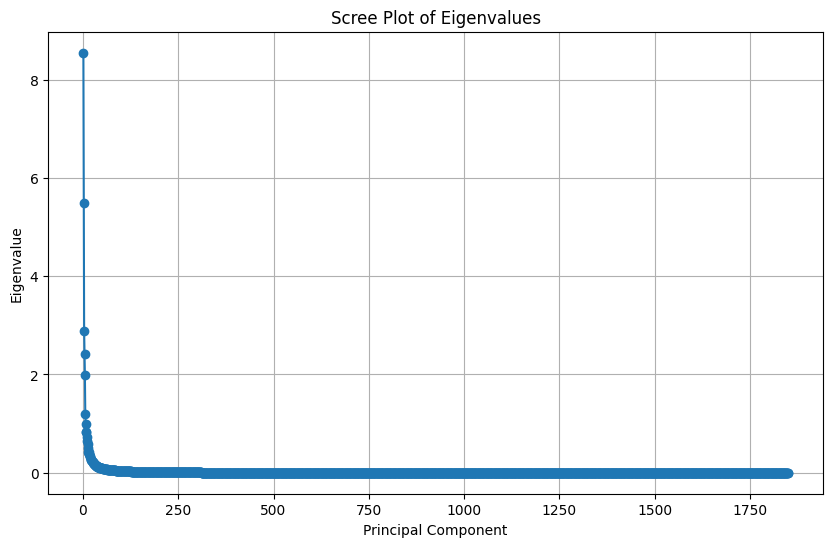

In [ ]:
# Calculate the eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

# Sort the eigenvectors by decreasing eigenvalues
sorted_indices = np.argsort(eigenvalues)[::-1]
eigenvalues_sorted = eigenvalues[sorted_indices]
eigenvectors_sorted = eigenvectors[:, sorted_indices]

# Plot the eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(eigenvalues_sorted) + 1), eigenvalues_sorted, marker='o', linestyle='-')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot of Eigenvalues')
plt.grid(True)
plt.show()

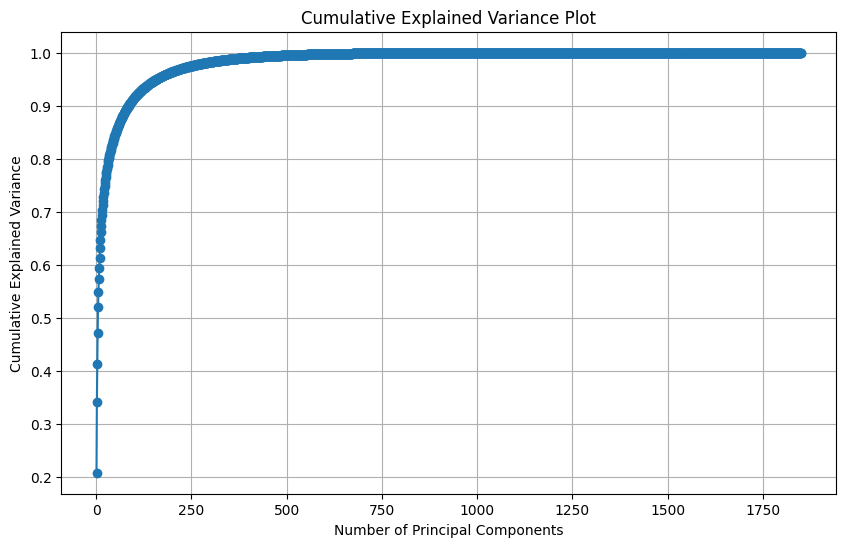

In [ ]:
explained_variance_ratio = eigenvalues_sorted / np.sum(eigenvalues_sorted)
cumulative_explained_variance = np.zeros_like(explained_variance_ratio)

for i in range(len(explained_variance_ratio)):
    cumulative_explained_variance[i] = np.sum(explained_variance_ratio[:i + 1])

cumulative_explained_variance = np.cumsum(eigenvalues_sorted) / np.sum(eigenvalues_sorted)

# Plotting the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()

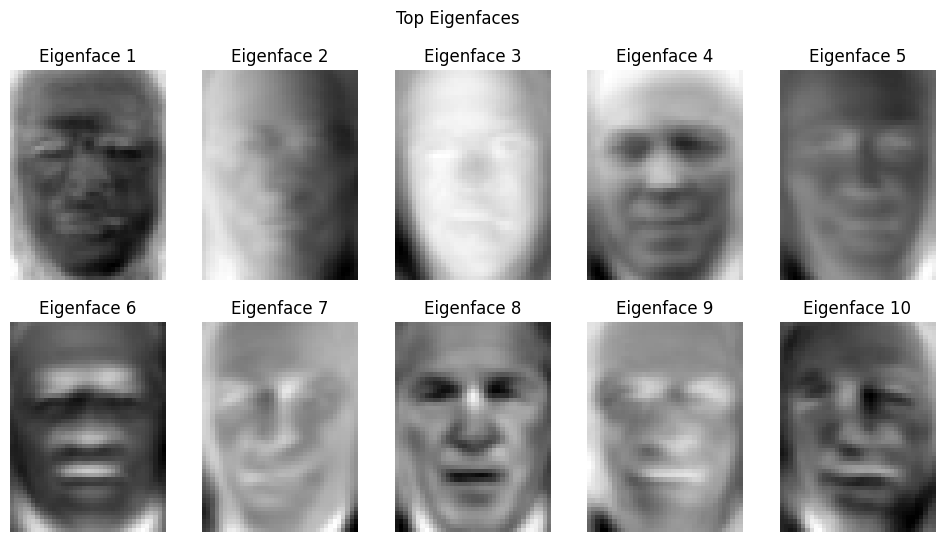

In [ ]:
# Selecting 10 the number of eigenfaces to visualize
num_eigenfaces = 10

# Get the top eigenfaces
top_eigenfaces = eigenvectors_sorted[:, :num_eigenfaces]

# Reshape the eigenfaces to match the original image size
eigenface_images = top_eigenfaces.reshape((lfw_people.images.shape[1], lfw_people.images.shape[2], num_eigenfaces))

# Plot the eigenfaces using a while loop
plt.figure(figsize=(12, 6))

i = 0
while i < num_eigenfaces:
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenface_images[:, :, i], cmap='gray')
    plt.title(f'Eigenface {i + 1}')
    plt.axis('off')

    i += 1

plt.suptitle('Top Eigenfaces')
plt.show()

In [ ]:
# Define the number of components for PCA
n_components = 150

# Select the top n_components eigenvectors
reduced_eigenvectors = eigenvectors_sorted[:, :n_components]

# Project the data onto the reduced eigenvectors
X_train_pca = np.dot(X_centered, reduced_eigenvectors)
X_test_pca = np.dot(X_test - mean, reduced_eigenvectors)

# Implementing Random Forest classifier after PCA

In [ ]:
# Initializing Random Forest Classifier with the help of sklearn
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=0)

# Training the classifier
rf_classifier.fit(X_train_pca, y_train)

# Predict labels for the test set
y_pred_rf = rf_classifier.predict(X_test_pca)

In [ ]:
def calculate_accuracy(y_true, y_pred):
    accuracy = np.sum(y_true == y_pred) / len(y_true)
    return accuracy

# Calculating the accuracy using random forest classifier
accuracy_rf = calculate_accuracy(y_test, y_pred_rf)

print(f"Custom Accuracy Score for Random Forest: {accuracy_rf:.4f}")

Custom Accuracy Score for Random Forest: 0.5349


In [ ]:
def get_classification_report_rf(y_true, y_pred, target_names=None):
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    num_classes = len(unique_classes)

    # Initialize variables to store per-class metrics
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i, c in enumerate(unique_classes):
        true_positive = np.sum((y_true == c) & (y_pred == c))
        false_positive = np.sum((y_true != c) & (y_pred == c))
        false_negative = np.sum((y_true == c) & (y_pred != c))

        precision[i] = true_positive / max((true_positive + false_positive), 1)
        recall[i] = true_positive / max((true_positive + false_negative), 1)
        f1_score[i] = 2 * (precision[i] * recall[i]) / max((precision[i] + recall[i]), 1)

    # Calculate overall metrics
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Construct the classification report
    report = f"{'':<15}{'Precision':<15}{'Recall':<15}{'F1 Score':<15}\n"
    for i, c in enumerate(unique_classes):
        report += f"{f'{target_names[c]}' if target_names is not None else 'Class '}{c:<14}{precision[i]:<15.4f}{recall[i]:<15.4f}{f1_score[i]:<15.4f}\n"

    report += f"\n{'Macro Average':<15}{macro_precision:<15.4f}{macro_recall:<15.4f}{macro_f1_score:<15.4f}"

    return report

def plot_confusion_matrix_rf(conf_matrix_rf, target_names=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix_rf, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Random Forest Confusion Matrix')
    plt.show()

Random Forest Classification Report:
                Precision      Recall         F1 Score       
Ariel Sharon0             0.0000         0.0000         0.0000         
Colin Powell1             0.7647         0.5098         0.6118         
Donald Rumsfeld2             1.0000         0.0526         0.1000         
George W Bush3             0.4764         0.9712         0.6392         
Gerhard Schroeder4             1.0000         0.1111         0.2000         
Hugo Chavez5             1.0000         0.0714         0.1333         
Tony Blair6             0.8750         0.2593         0.4000         

Macro Average  0.7309         0.2822         0.2978         


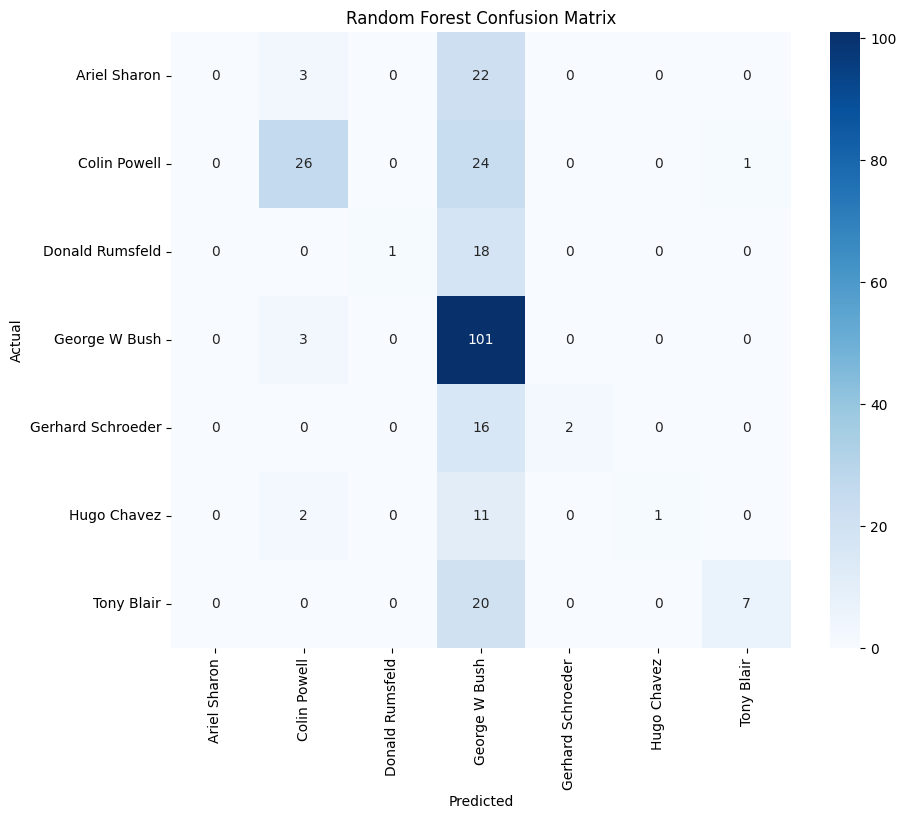

In [ ]:
# Calculate and print custom classification report for Random Forest
report_rf = get_classification_report_rf(y_test, y_pred_rf, target_names=lfw_people.target_names)
print("Random Forest Classification Report:\n", report_rf)

# Calculate and plot custom confusion matrix for Random Forest
conf_matrix_rf = get_confusion_matrix(y_test, y_pred_rf, num_classes=len(lfw_people.target_names))
plot_confusion_matrix_rf(conf_matrix_rf, target_names=lfw_people.target_names)

# Implementing KNN Classifier after PCA

In [ ]:
def k_nearest_neighbors(X_train, y_train, X_test, k=5):
    n_test = X_test.shape[0]
    y_pred = np.zeros(n_test, dtype=int)

    i = 0
    while i < n_test:
        # Calculate distances from the test sample to all training samples
        distances = np.linalg.norm(X_train - X_test[i], axis=1)

        # Find the indices of the k-nearest neighbors
        nearest_indices = np.argsort(distances)[:k]

        # Get the labels of the k-nearest neighbors
        nearest_labels = y_train[nearest_indices]

        # Predict the class based on the majority class among neighbors
        unique, counts = np.unique(nearest_labels, return_counts=True)
        y_pred[i] = unique[np.argmax(counts)]

        i += 1

    return y_pred

In [ ]:
def accuracy_score(y_true, y_pred):
    correct_predictions = np.sum(y_true == y_pred)
    total_samples = len(y_true)
    accuracy = correct_predictions / total_samples
    return accuracy

In [ ]:
# Define the number of neighbors (k)
k = 9

# Use the k-NN classifier to make predictions with PCA
y_pred_knn_pca = k_nearest_neighbors(X_train_pca, y_train, X_test_pca, k)

# Evaluate the k-NN classifier with PCA
accuracy_knn_pca = accuracy_score(y_test, y_pred_knn_pca)
print(f"k-NN with PCA Accuracy: {accuracy_knn_pca:.4f}")

k-NN with PCA Accuracy: 0.5736


In [ ]:
def get_classification_report(y_true, y_pred, target_names=None):
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    num_classes = len(unique_classes)

    # Initialize variables to store per-class metrics
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1_score = np.zeros(num_classes)

    for i, c in enumerate(unique_classes):
        true_positive = np.sum((y_true == c) & (y_pred == c))
        false_positive = np.sum((y_true != c) & (y_pred == c))
        false_negative = np.sum((y_true == c) & (y_pred != c))

        precision[i] = true_positive / max((true_positive + false_positive), 1)
        recall[i] = true_positive / max((true_positive + false_negative), 1)
        f1_score[i] = 2 * (precision[i] * recall[i]) / max((precision[i] + recall[i]), 1)

    # Calculate overall metrics
    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1_score = np.mean(f1_score)

    # Construct the classification report
    report = f"{'':<15}{'Precision':<15}{'Recall':<15}{'F1 Score':<15}\n"
    for i, c in enumerate(unique_classes):
        report += f"{f'{target_names[c]}' if target_names is not None else 'Class '}{c:<14}{precision[i]:<15.4f}{recall[i]:<15.4f}{f1_score[i]:<15.4f}\n"

    report += f"\n{'Macro Average':<15}{macro_precision:<15.4f}{macro_recall:<15.4f}{macro_f1_score:<15.4f}"

    return report



def plot_confusion_matrix(conf_matrix, target_names=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

k-NN with PCA Classification Report:
                Precision      Recall         F1 Score       
Ariel Sharon0             1.0000         0.1200         0.2143         
Colin Powell1             0.5410         0.6471         0.5893         
Donald Rumsfeld2             0.5000         0.3158         0.3158         
George W Bush3             0.5855         0.8558         0.6953         
Gerhard Schroeder4             0.4444         0.2222         0.1975         
Hugo Chavez5             1.0000         0.2143         0.3529         
Tony Blair6             0.5556         0.3704         0.4115         

Macro Average  0.6609         0.3922         0.3967         


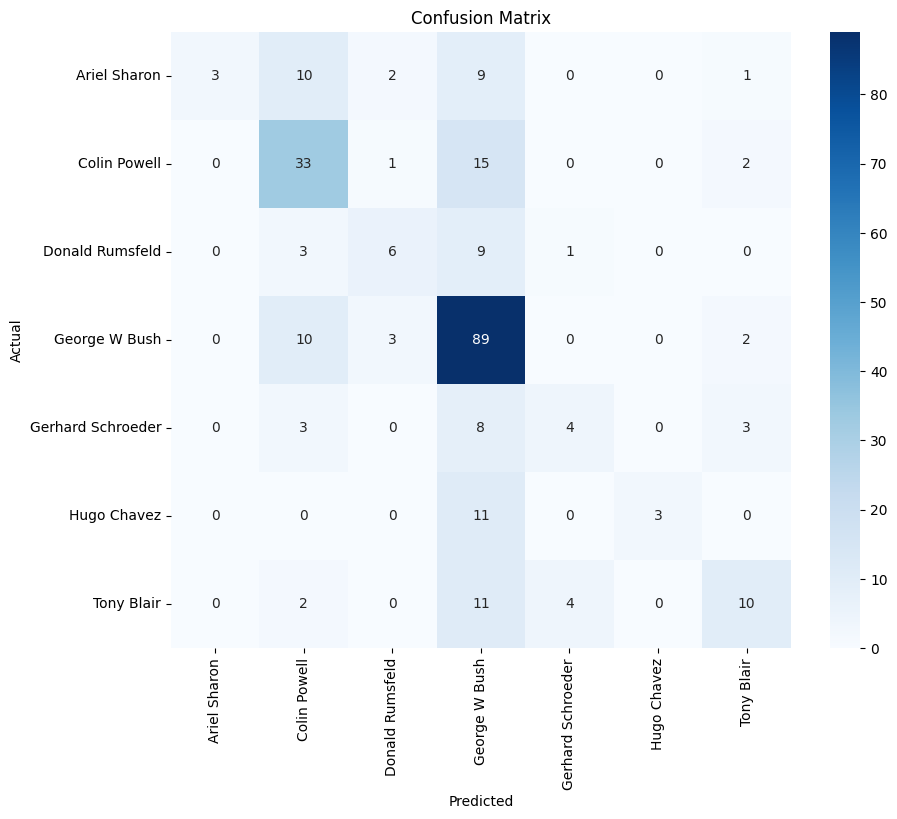

In [ ]:
# Display a classification report for k-NN with PCA
num_classes = len(np.unique(np.concatenate([y_test, y_pred_knn_pca])))
report_knn_pca = get_classification_report(y_test, y_pred_knn_pca, target_names=lfw_people.target_names)
print("k-NN with PCA Classification Report:\n", report_knn_pca)

# Create a confusion matrix for k-NN with PCA
conf_matrix_knn_pca = get_confusion_matrix(y_test, y_pred_knn_pca, num_classes)

# Plot the confusion matrix for k-NN with PCA as a heatmap
plot_confusion_matrix(conf_matrix_knn_pca, target_names=lfw_people.target_names)

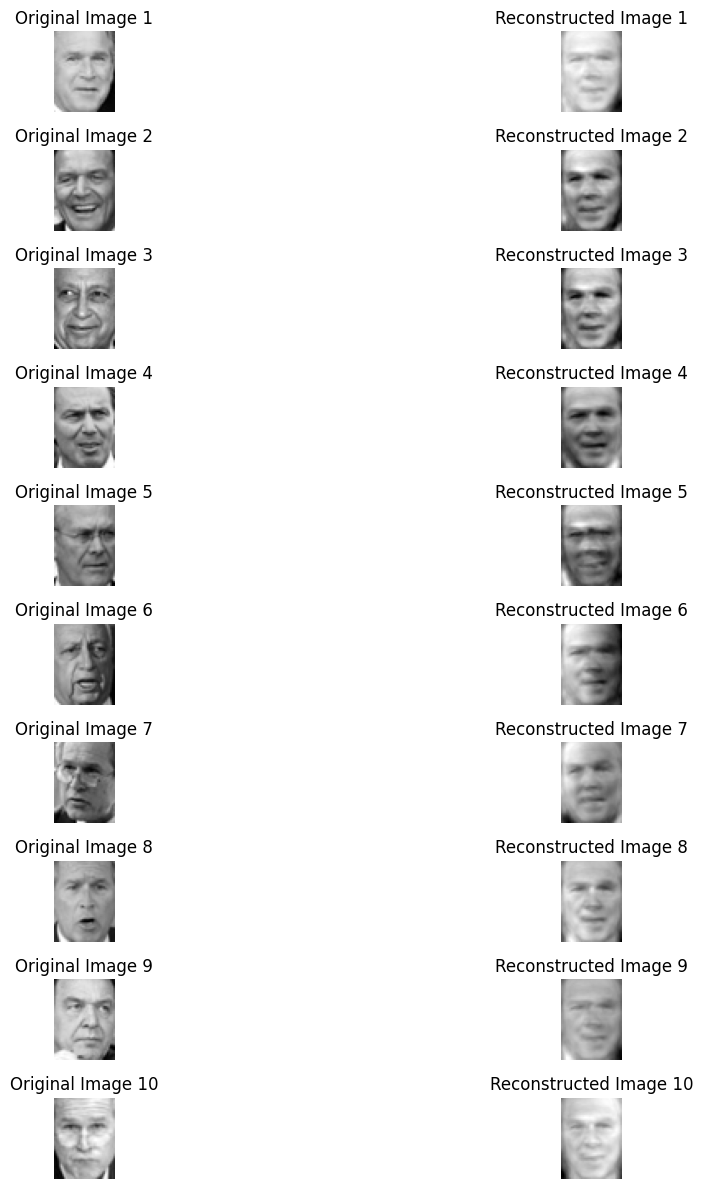

In [32]:
# Selecting a subset of the top eigenfaces to visualize
num_eigenfaces_to_visualize = 10

# Get the top eigenfaces
top_eigenfaces = eigenvectors_sorted[:, :num_eigenfaces_to_visualize]

# Reshape the eigenfaces to match the original image size
eigenface_images = top_eigenfaces.reshape((lfw_people.images.shape[1], lfw_people.images.shape[2], num_eigenfaces_to_visualize))

# Randomly choose 10 images for visualization
random_indices = np.random.choice(len(lfw_people.images), size=10, replace=False)

# Plot the original and reconstructed images for the selected subset
plt.figure(figsize=(15, 12))

for i, idx in enumerate(random_indices):
    # Original Image
    plt.subplot(10, 2, 2 * i + 1)
    plt.imshow(lfw_people.images[idx], cmap='gray')
    plt.title(f'Original Image {i + 1}')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(10, 2, 2 * i + 2)
    original_image = lfw_people.images[idx].flatten()
    reconstructed_image = np.dot(top_eigenfaces, np.dot(top_eigenfaces.T, original_image))
    reconstructed_image = reconstructed_image.reshape((lfw_people.images.shape[1], lfw_people.images.shape[2]))
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title(f'Reconstructed Image {i + 1}')
    plt.axis('off')

plt.tight_layout()
plt.show()